## 1. Nauka klasyfikatora

Dokumentacja: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [2]:
from generating_data import generate_checkerboard, generate_data

In [3]:
x, y = generate_checkerboard(n_size=3, n_samples=1000)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import timeit
import time
import pandas as pd

experiment_data = []

n_dimensions_experiments = [2, 3, 10]
n_samples_experiments = [200, 400, 1000, 2000, 4000]

for n_dimensions in n_dimensions_experiments:
    for n_samples in n_samples_experiments:
        X, y, _ = generate_data(n_dimension=n_dimensions, n_samples=n_samples, noise=False)

        # test, train split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

        # parameters
        algorithms = ['ball_tree', 'kd_tree', 'brute']
        leaf_sizes = [2, 30, 100]
        n_neighbors = [3, 7, 9, 27, 65, 99]

        # fitting algorithms and caculating score
        for a in algorithms:
            for l in leaf_sizes:
                for n in n_neighbors:
                    knn = KNeighborsClassifier(n_neighbors=n, leaf_size=l, algorithm=a)
                    time_fit_start = time.time()
                    knn.fit(X_train, y_train)
                    time_fit_end = time.time()
                    time_fit = time_fit_end - time_fit_start

                    time_predict_start = time.time()
                    score = knn.score(X_test, y_test)
                    time_predict_end = time.time()
                    time_predict = time_predict_end - time_fit_start
                    experiment_data.append([n_dimensions, n_samples, n, l, a, score, time_predict, time_predict])
            
df = pd.DataFrame(experiment_data, columns = ['n_dimensions', 'n_samples', 'n_neigbors', 'leaf_size', 'algorithm', 'score', 'time_fit', 'time_predict'])
df = df.set_index(['n_dimensions','n_samples'])
df

n_neigbors  leaf_size  algorithm   score  time_fit  \
n_dimensions n_samples                                                       
2            200                 3          2  ball_tree  0.9700  0.008998   
             200                 7          2  ball_tree  0.9800  0.007001   
             200                 9          2  ball_tree  0.9800  0.009001   
             200                27          2  ball_tree  0.9900  0.008002   
             200                65          2  ball_tree  0.9700  0.009997   
...                            ...        ...        ...     ...       ...   
10           4000                7        100      brute  0.8875  0.208000   
             4000                9        100      brute  0.8950  0.217999   
             4000               27        100      brute  0.9085  0.212007   
             4000               65        100      brute  0.9280  0.230996   
             4000               99        100      brute  0.9335  0.242999   

                        time_predict  
n_dimensions n_samples                
2            200            0.008998  
             200            0.007001  
             200            0.009001  
             200            0.008002  
             200            0.009997  
...                              ...  
10           4000           0.208000  
             4000           0.217999  
             4000           0.212007  
             4000           0.230996  
             4000           0.242999  

[810 rows x 6 columns]

In [70]:
df.to_csv('experiment_data.csv') 

## 2. Interpretacja zebranych danych

In [6]:
import pandas as pd
df = pd.read_csv('experiment_data.csv')
df = df.set_index(['n_dimensions','n_samples'])
df['time'] = df['time_fit'] + df['time_predict']

### 2.1 Dla każdego zbioru wyznaczyć optymalna wartość parametru $k$

In [7]:
best_k = df.loc[(df['leaf_size'] == 30) & (df['algorithm'] == 'brute')]
df

n_neigbors  leaf_size  algorithm   score  time_fit  \
n_dimensions n_samples                                                       
2            200                 3          2  ball_tree  0.9700  0.008998   
             200                 7          2  ball_tree  0.9800  0.007001   
             200                 9          2  ball_tree  0.9800  0.009001   
             200                27          2  ball_tree  0.9900  0.008002   
             200                65          2  ball_tree  0.9700  0.009997   
...                            ...        ...        ...     ...       ...   
10           4000                7        100      brute  0.8875  0.208000   
             4000                9        100      brute  0.8950  0.217999   
             4000               27        100      brute  0.9085  0.212007   
             4000               65        100      brute  0.9280  0.230996   
             4000               99        100      brute  0.9335  0.242999   

                        time_predict      time  
n_dimensions n_samples                          
2            200            0.008998  0.017997  
             200            0.007001  0.014002  
             200            0.009001  0.018003  
             200            0.008002  0.016005  
             200            0.009997  0.019995  
...                              ...       ...  
10           4000           0.208000  0.416001  
             4000           0.217999  0.435999  
             4000           0.212007  0.424015  
             4000           0.230996  0.461992  
             4000           0.242999  0.485998  

[810 rows x 7 columns]

## 3. Granica separacji

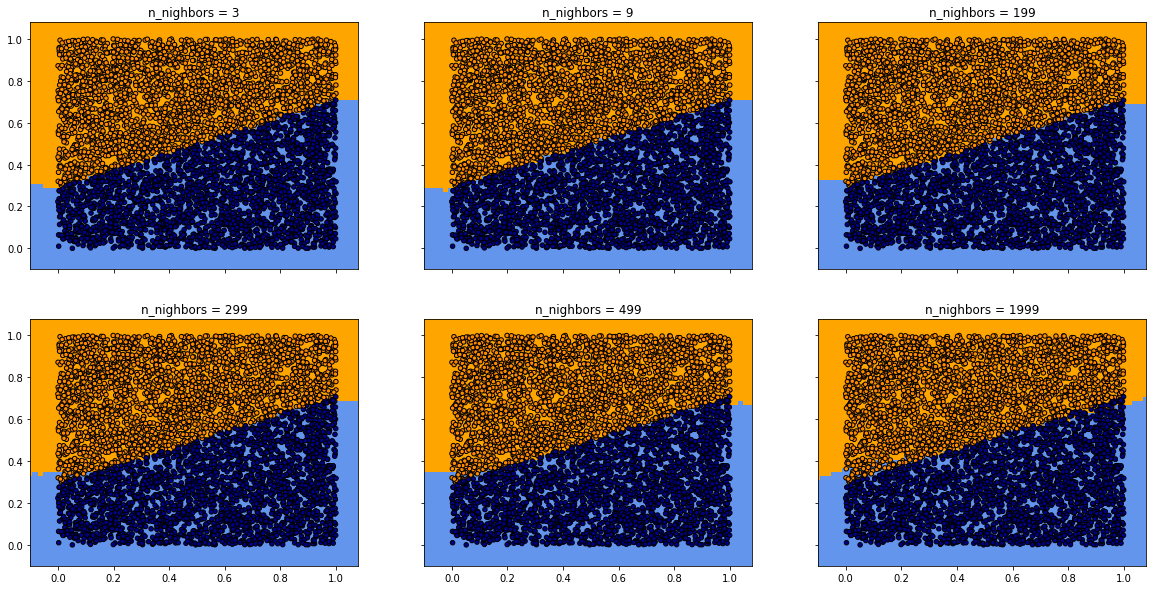

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

X, y, _ = generate_data(n_dimension=2, n_samples=5000, noise=False)

# parameters
n_neighbors = [3, 9, 199, 299, 499, 1999]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(20, 10))

for idx, n in enumerate(n_neighbors):
    # fitting algorithms and caculating score
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X, y)

    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    # generate points in whole domain
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax = axs.flat[idx]
    
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y,
                edgecolor='k', s=20, cmap=cmap_bold)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(f"n_nighbors = {n}")


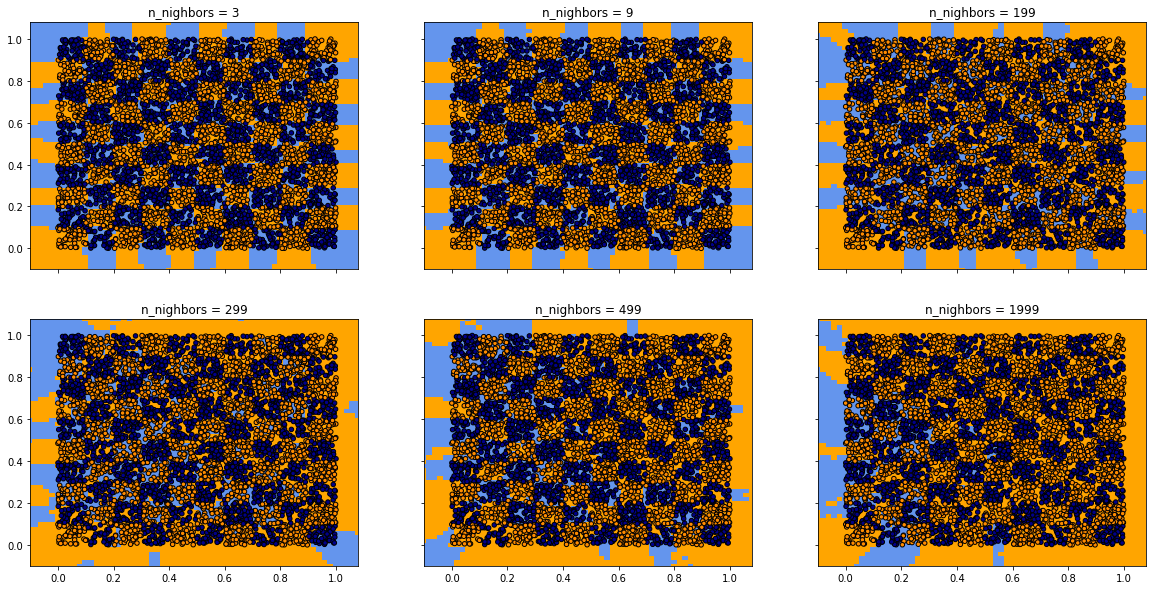

In [50]:
X, y = generate_checkerboard(n_size=10, n_samples=5000)

# parameters
n_neighbors = [3, 9, 199, 299, 499, 1999]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(20, 10))

for idx, n in enumerate(n_neighbors):
    # fitting algorithms and caculating score
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X, y)

    # # Create color maps
    # cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    # cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    # generate points in whole domain
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    ax = axs.flat[idx]
    
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y,
                edgecolor='k', s=20, cmap=cmap_bold)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(f"n_nighbors = {n}")
